In [5]:
def stock_pred_feature(stock_id):
    import pandas as pd
    raw_df = pd.read_csv("lstm_dataset_dropna.csv")
    mask=raw_df['stock_id']==int(stock_id)
    df=raw_df[mask]
    daily_df = pd.read_csv("daily.csv")
    mask=daily_df['stock_id']==int(stock_id)
    daily_df=daily_df[mask]
    daily_df=daily_df[["date","Close"]]
    merge_df=pd.merge(df,daily_df,on="date",how="inner")
    df=merge_df
    
    def normalize(df):
        from sklearn import preprocessing

        newdf= df.copy()
        #newdf =newdf.reset_index()

        min_max_scaler = preprocessing.MinMaxScaler()

        newdf['ADXR'] = min_max_scaler.fit_transform(df.ADXR.values.reshape(-1,1))
        newdf['AVGPRICE'] = min_max_scaler.fit_transform(df.AVGPRICE.values.reshape(-1,1))
        newdf['OBV'] = min_max_scaler.fit_transform(df.OBV.values.reshape(-1,1))
        newdf['MINUS_DM'] = min_max_scaler.fit_transform(df.MINUS_DM.values.reshape(-1,1))
        newdf['WMA'] = min_max_scaler.fit_transform(df.WMA.values.reshape(-1,1))
        newdf['TYPPRICE'] = min_max_scaler.fit_transform(df.TYPPRICE.values.reshape(-1,1))
        newdf['TEMA'] = min_max_scaler.fit_transform(df.TEMA.values.reshape(-1,1))
        newdf['UPPERBBANDS'] = min_max_scaler.fit_transform(df.UPPERBBANDS.values.reshape(-1,1))
        newdf['DEMA'] = min_max_scaler.fit_transform(df.DEMA.values.reshape(-1,1))
        newdf['WCLPRICE'] = min_max_scaler.fit_transform(df.WCLPRICE.values.reshape(-1,1))
        newdf['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
        newdf=newdf[['ADXR', 'AVGPRICE', 'OBV', 'MINUS_DM', 'WMA', 'TYPPRICE','TEMA','UPPERBBANDS', 'DEMA', 'WCLPRICE','Close']]
        return newdf
    dataset_norm= normalize(df)
    
    import numpy as np

    def data_helper(newdf, time_frame):

        # 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
        number_features = len(newdf.columns)

        # 將dataframe 轉成 numpy array
        datavalue = newdf.to_numpy() 

        result = []
        # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
        for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
            result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance

        result = np.array(result)
        number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料

        x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
        y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案

        # 測試資料
        x_test = result[int(number_train):, :-1]
        y_test = result[int(number_train):, -1][:,-1]

        # 將資料組成變好看一點
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

        return [x_train, y_train, x_test, y_test]

    # 以20天為一區間進行股價預測
    X_train, y_train, X_test, y_test = data_helper(dataset_norm, 20)
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.layers.recurrent import LSTM
    import keras

    def build_model(input_length, input_dim):
        d = 0.3
        model = Sequential()

        model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
        model.add(Dropout(d))

        model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
        model.add(Dropout(d))

        model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
        model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

        model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
        model.summary()
        return model

    # 20天、11維
    model = build_model(20, 11)
    # 一個batch有128個instance，總共跑50個迭代
    model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1, verbose=1)
    import os
    if not os.path.exists("model"):
        os.makedirs("model")
    model.save("model/Feature_{}".format(stock_id))
    def denormalize(df, norm_value):
        from sklearn import preprocessing
        original_value = df['Close'].values.reshape(-1,1) #用收盤價畫出預測
        norm_value = norm_value.reshape(-1,1)

        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit_transform(original_value)
        denorm_value = min_max_scaler.inverse_transform(norm_value)

        return denorm_value

    # 用訓練好的 LSTM 模型對測試資料集進行預測
    pred = model.predict(X_test)

    # 將預測值與正確答案還原回原來的區間值
    denorm_pred = denormalize(df, pred) #預測值
    denorm_ytest = denormalize(df, y_test) #實際值
    def csv_export(stock_id):
        import os
        import pandas as pd
        df=pd.DataFrame(denorm_pred,columns=["Prediction"])
        df1=pd.DataFrame(denorm_ytest,columns=["Answer"])
        frames = [df, df1]
        df2=pd.concat(frames,axis=1)
        if not os.path.exists("csv"):
            os.makedirs("csv")
        df2.to_csv("csv/Feature_Keras_LSTM_{}.csv".format(stock_id),encoding='utf-8')

    csv_export(stock_id)
    #繪圖並輸出圖檔
    def chart(stock_id):
        import os
        import matplotlib.pyplot as plt
        %matplotlib inline  

        plt.plot(denorm_pred,color='red', label='Prediction')
        plt.plot(denorm_ytest,color='blue', label='Answer')
        plt.legend(loc='best')
        if not os.path.exists("png"):
            os.makedirs("png")
        plt.savefig("png/Feature_Keras_LSTM_{}.png".format(stock_id))
        plt.show()
    chart(stock_id)

In [6]:
def date_list(stock_id):
    import pandas as pd
    import os
    df= pd.read_csv('test_date.csv',index_col=0) #先以每日交易量做預測
    df1= pd.read_csv('csv/Feature_Keras_LSTM_{}.csv'.format(stock_id),index_col=0) #先以每日交易量做預測
    df=df.iloc[:,1:3]
    df2=pd.concat([df,df1], ignore_index=False,axis=1)
    if not os.path.exists("csv2"):
        os.makedirs("csv2")
    df2.to_csv("csv2/Feature_Keras_LSTM_{}.csv".format(stock_id))

In [7]:
def Plot(stock_id):
    import pandas as pd
    import numpy as np
    import os
    df=pd.read_csv("csv2/Feature_Keras_LSTM_{}.csv".format(stock_id),encoding='utf-8',index_col=0)
    prediction=np.array(df["Prediction"])
    answer=np.array(df["Answer"])
    date=pd.to_datetime(df["end-date"])

    import matplotlib.pyplot as plt
    import datetime as dt
    import matplotlib.dates as mdates
    %matplotlib inline  

    plt.figure(figsize=(14,10))
    #x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date]
    plt.plot(date,prediction,color='red', label='Prediction')
    plt.plot(date,answer,color='blue', label='Answer')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    plt.gcf().autofmt_xdate()
    plt.legend(loc='best')
    font = {'size': 24}
    plt.rc('font', **font)
    if not os.path.exists("png2"):
        os.makedirs("png2")
    plt.savefig("png2/Feature_Keras_Keras_LSTM_{}.png".format(stock_id))
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           274432    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
__________________________________________________

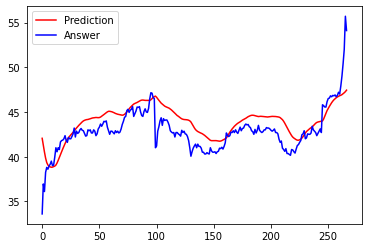

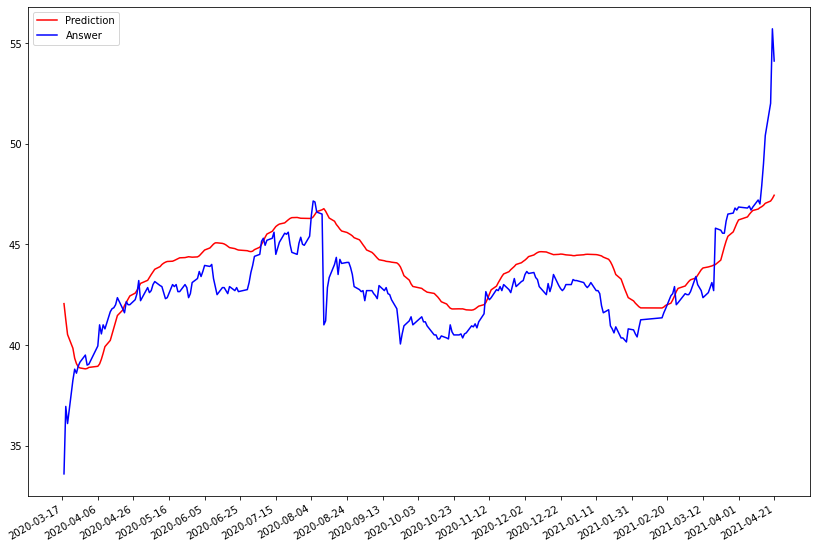

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 256)           274432    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

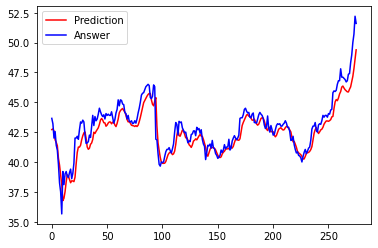

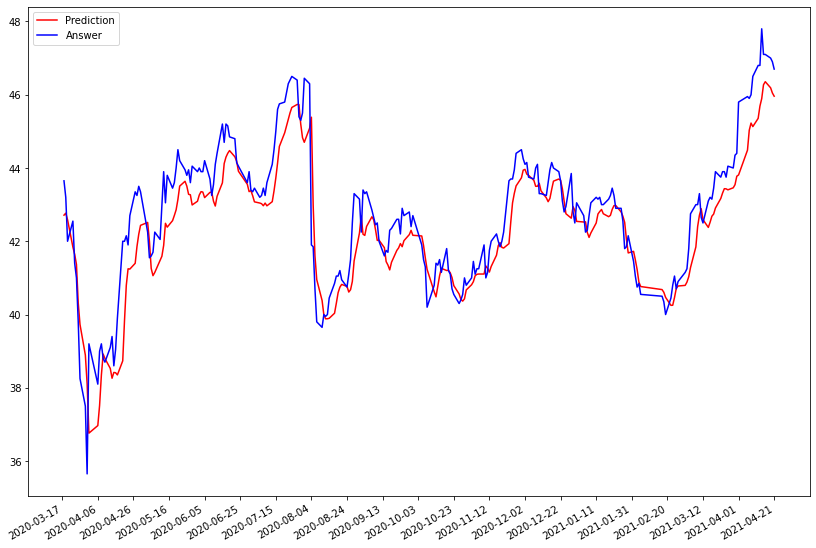

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 256)           274432    
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

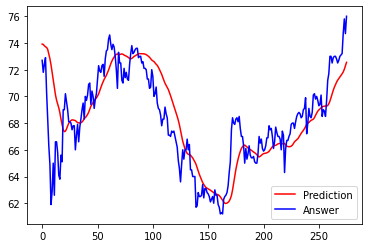

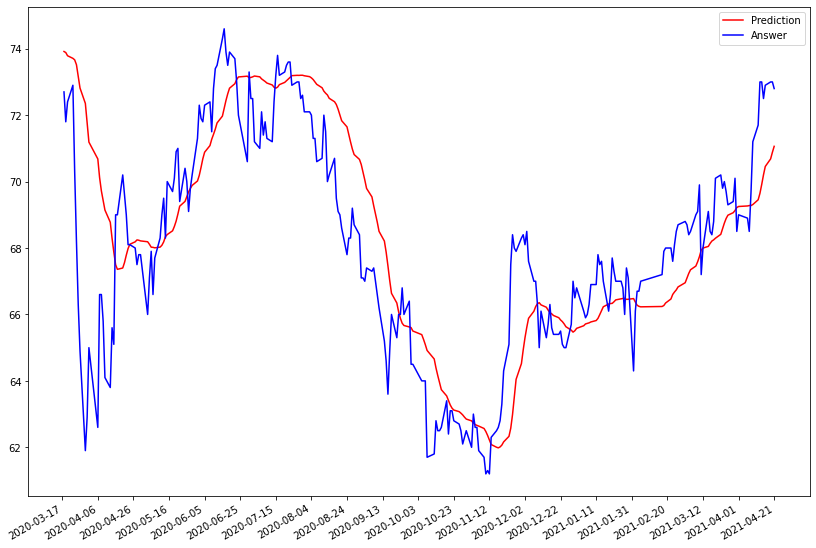

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 256)           274432    
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

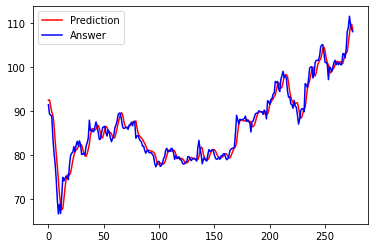

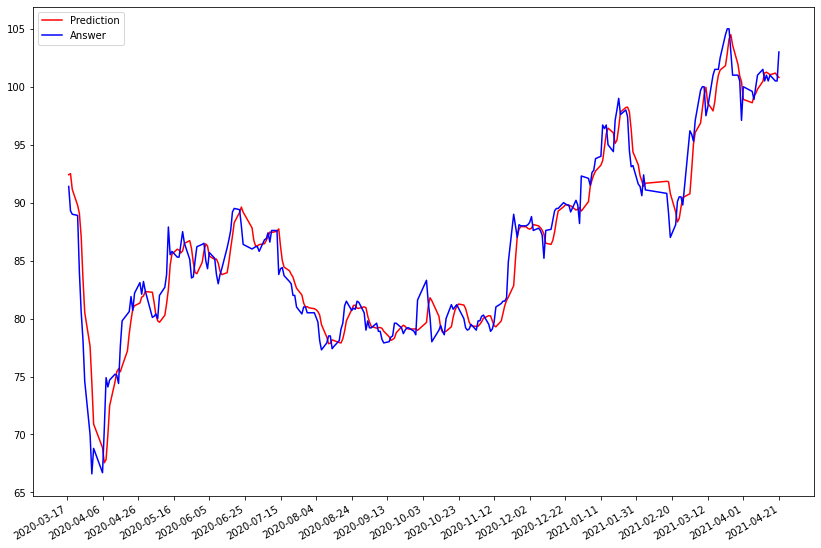

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 256)           274432    
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

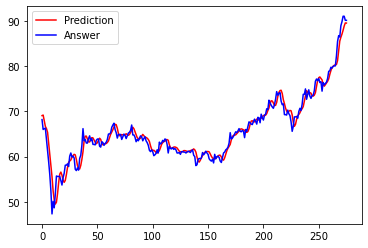

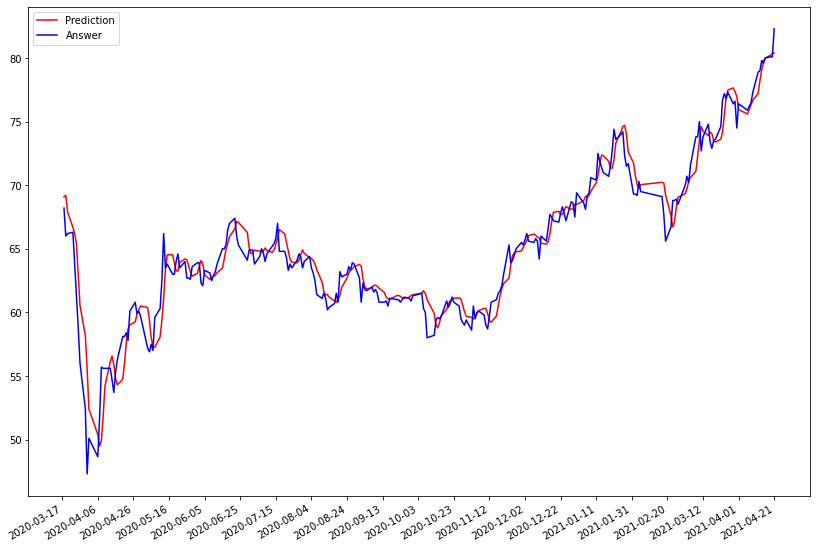

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

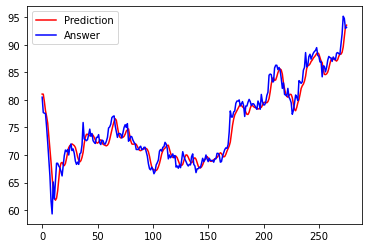

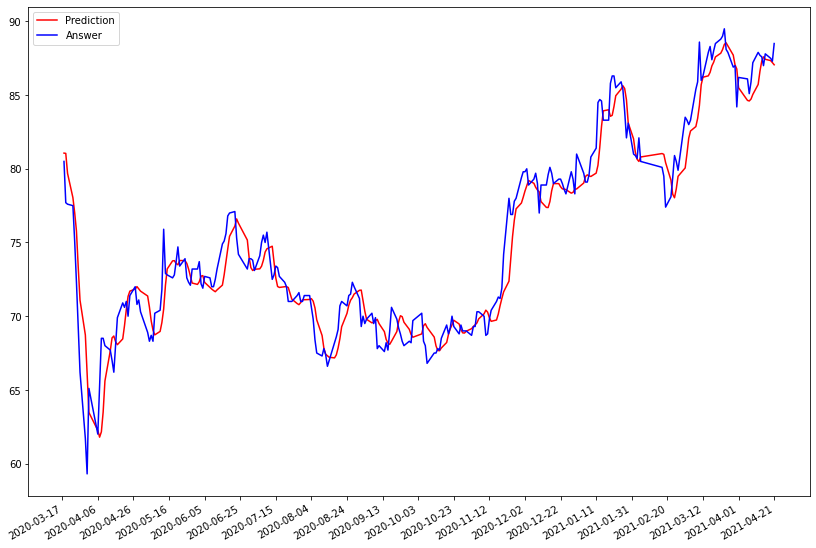

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

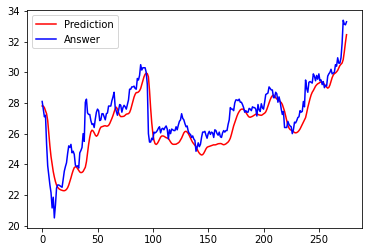

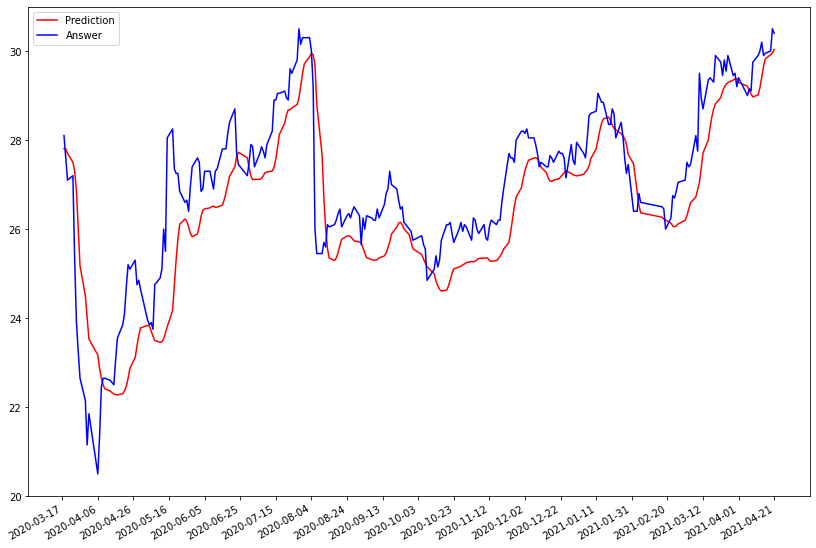

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

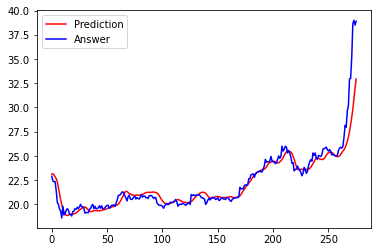

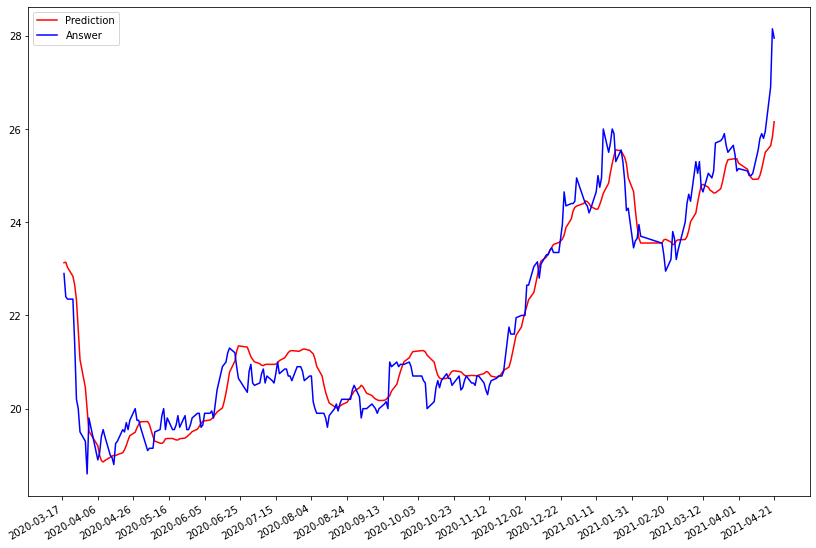

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

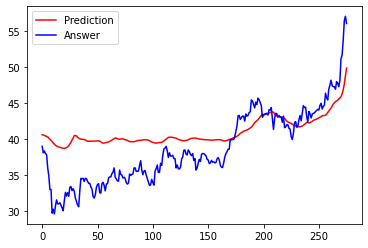

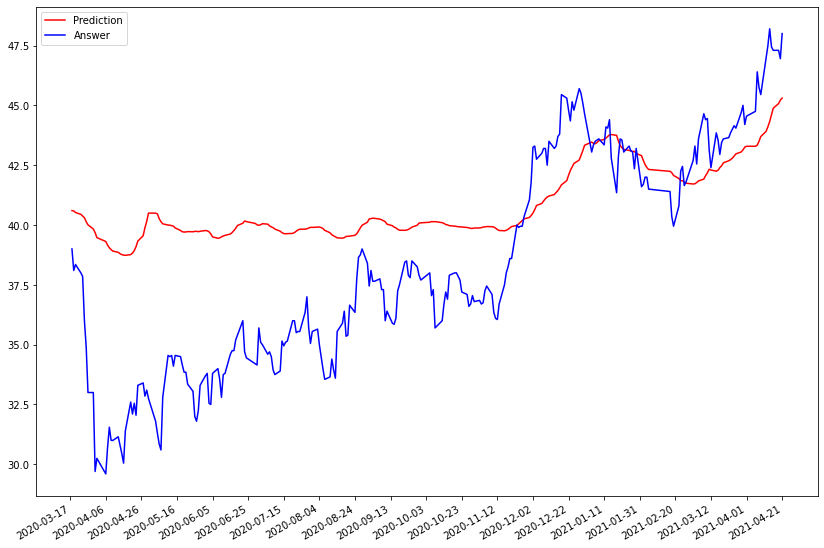

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_18 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
________________________________________________

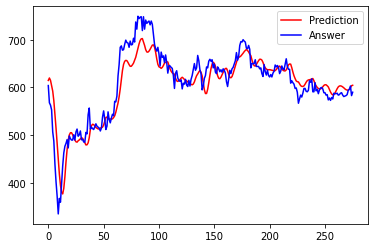

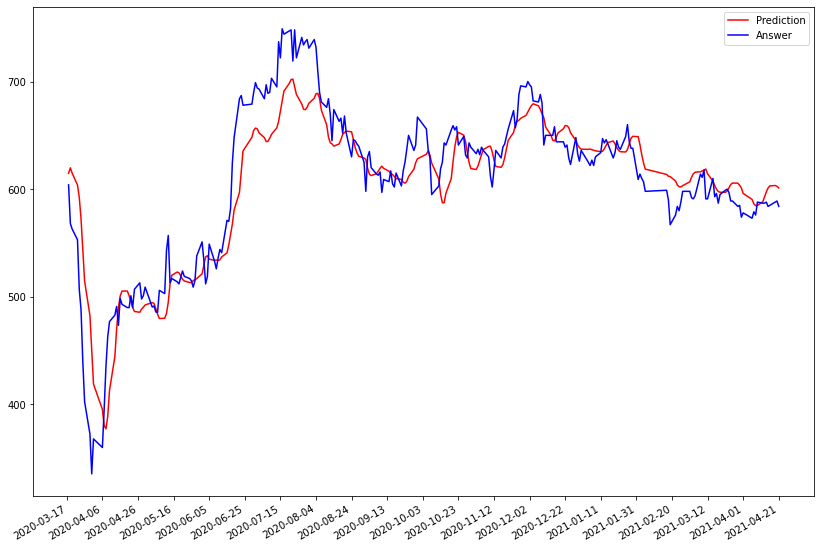

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

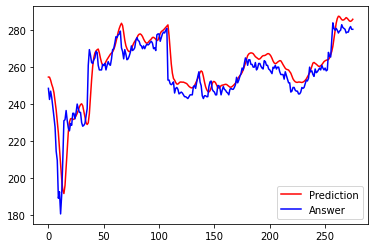

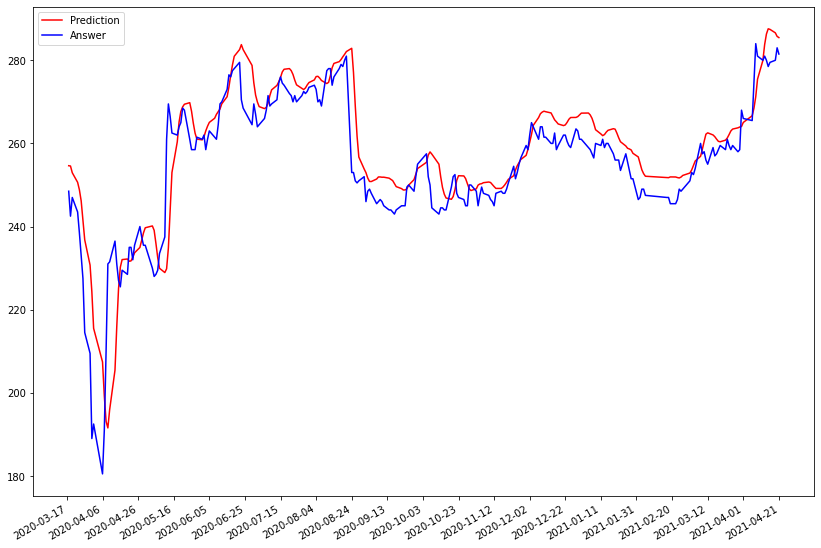

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

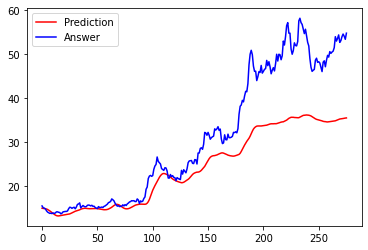

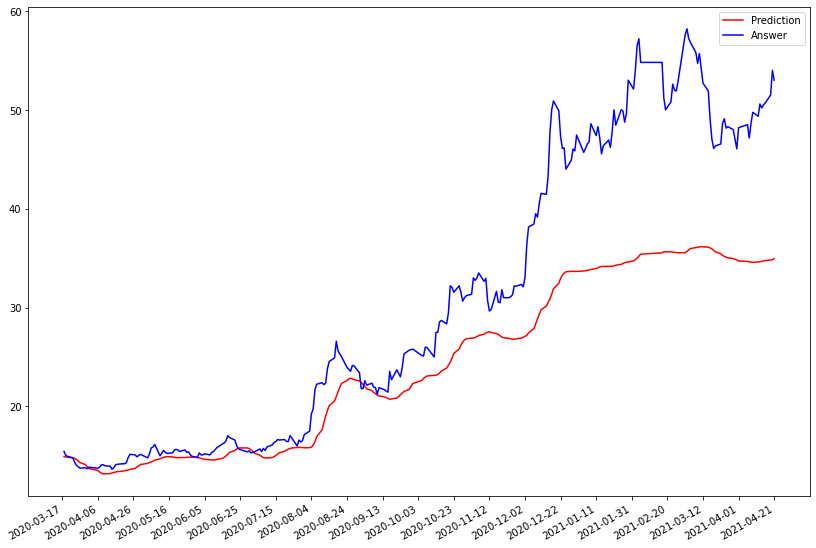

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

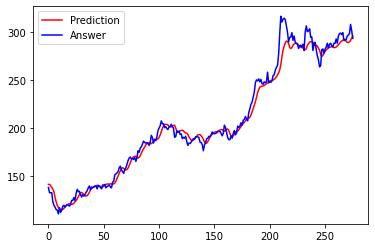

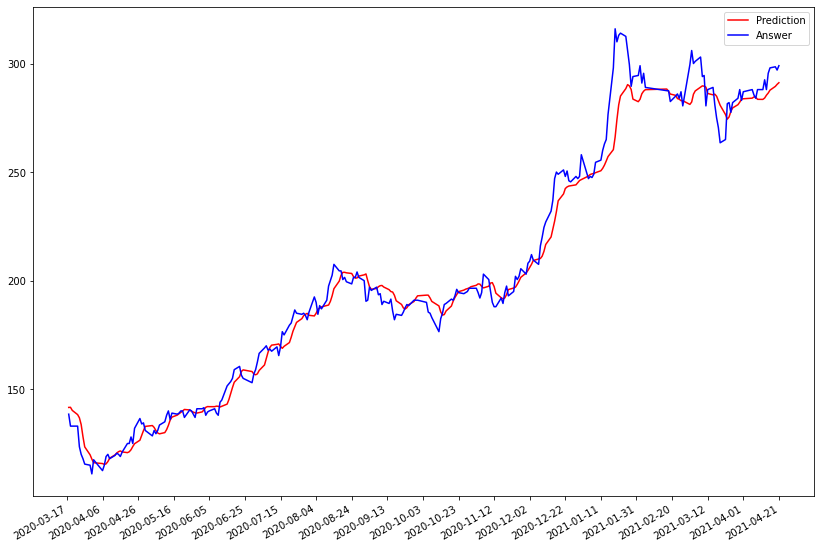

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

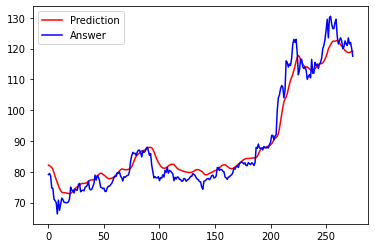

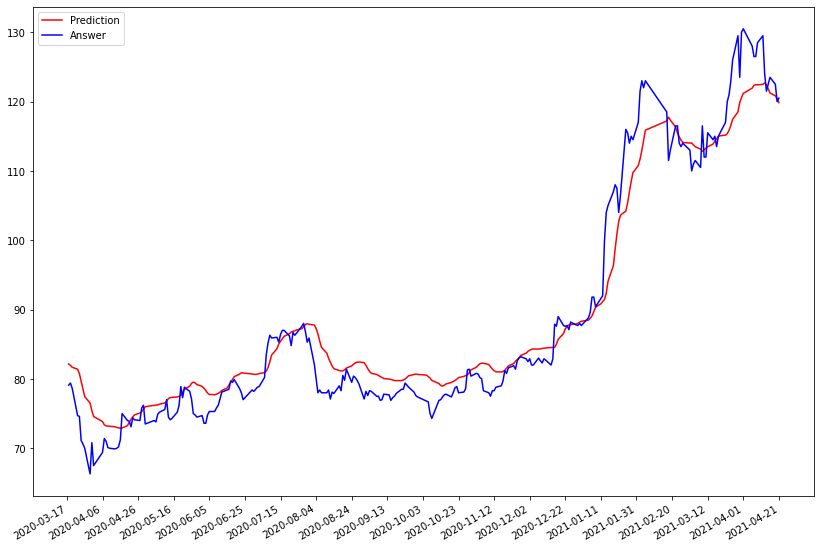

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_28 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

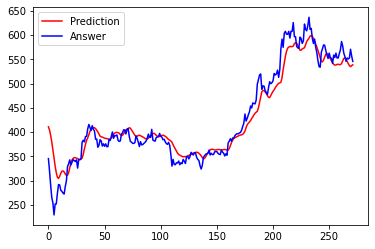

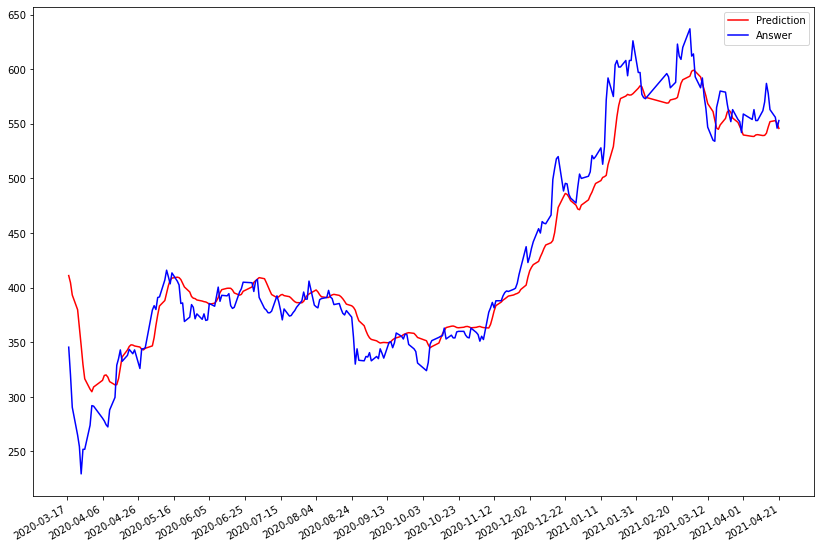

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_30 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

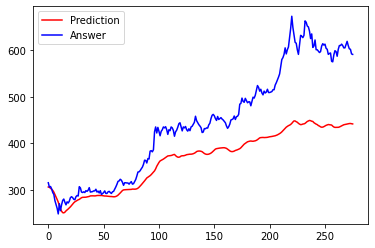

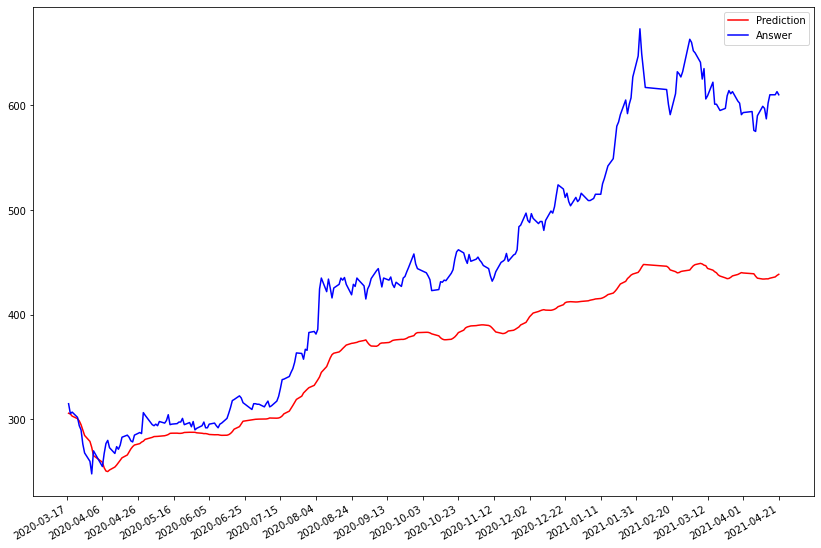

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_32 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

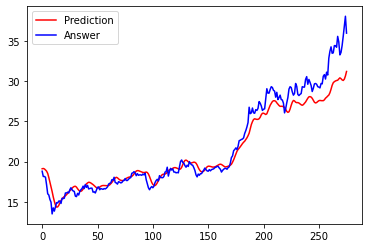

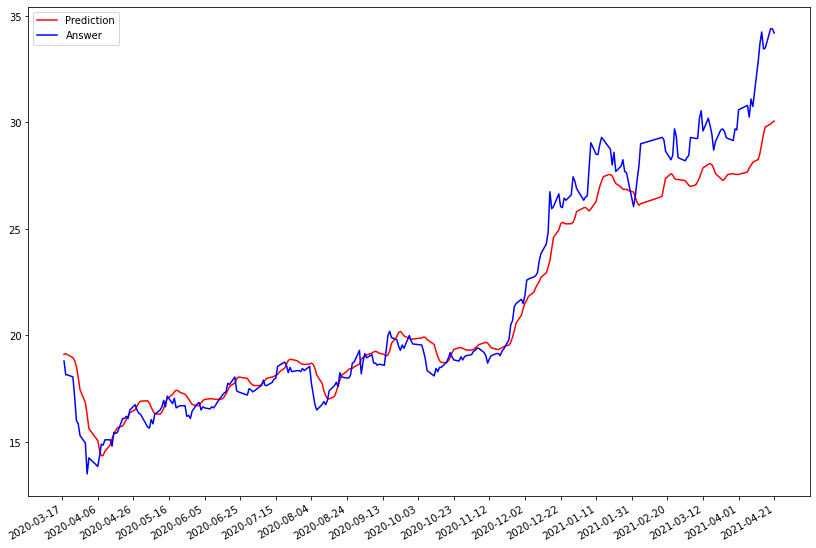

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_34 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

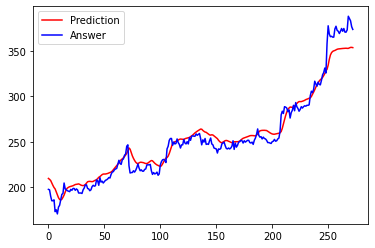

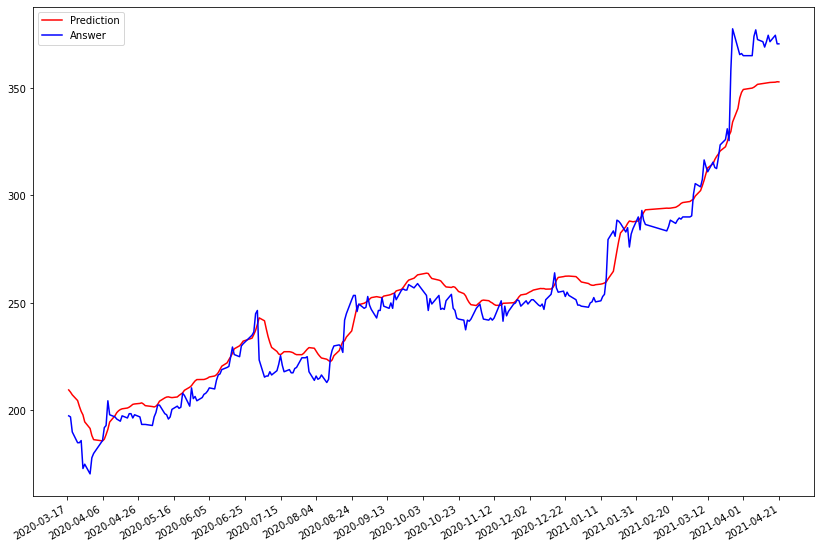

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_36 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

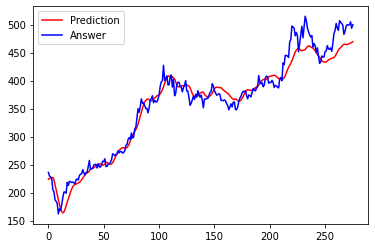

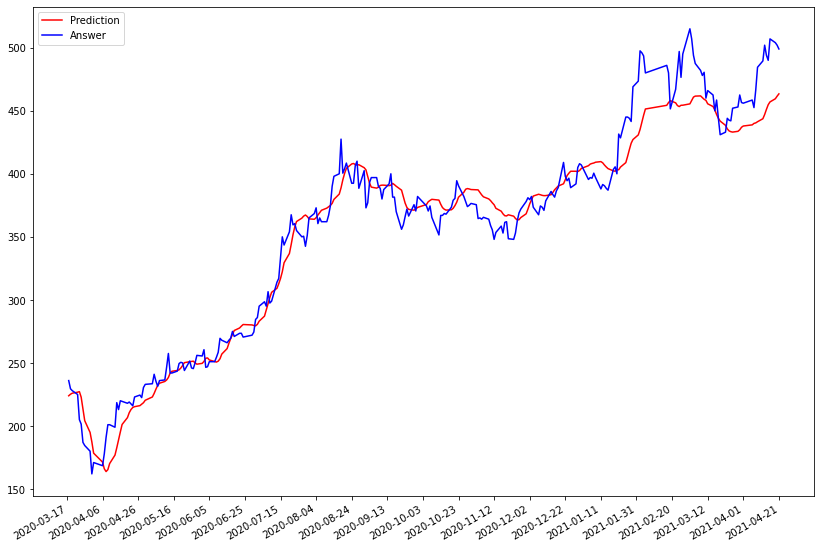

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_38 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

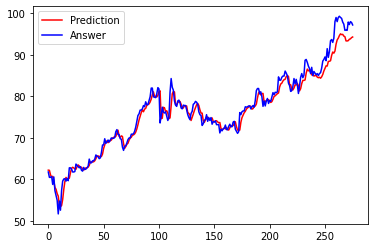

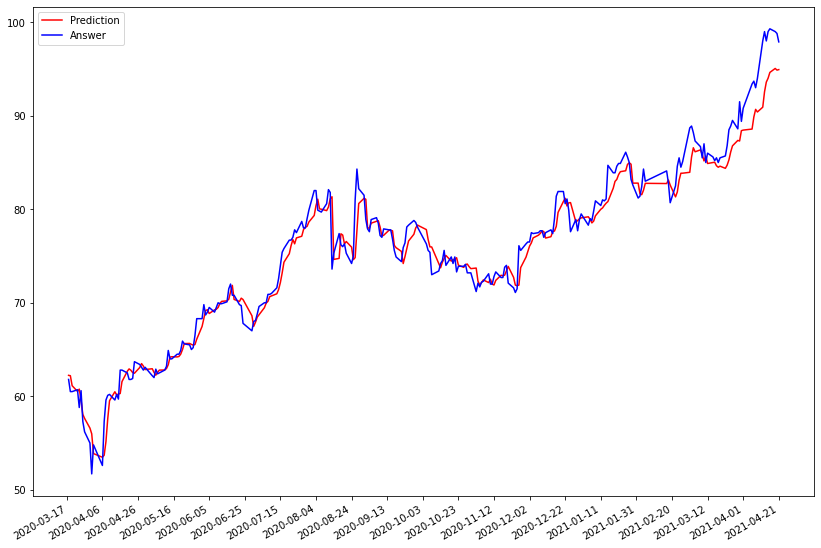

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_40 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

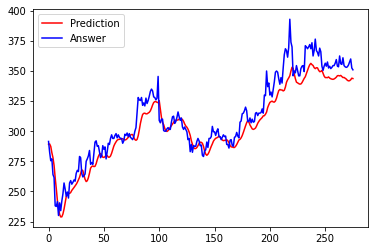

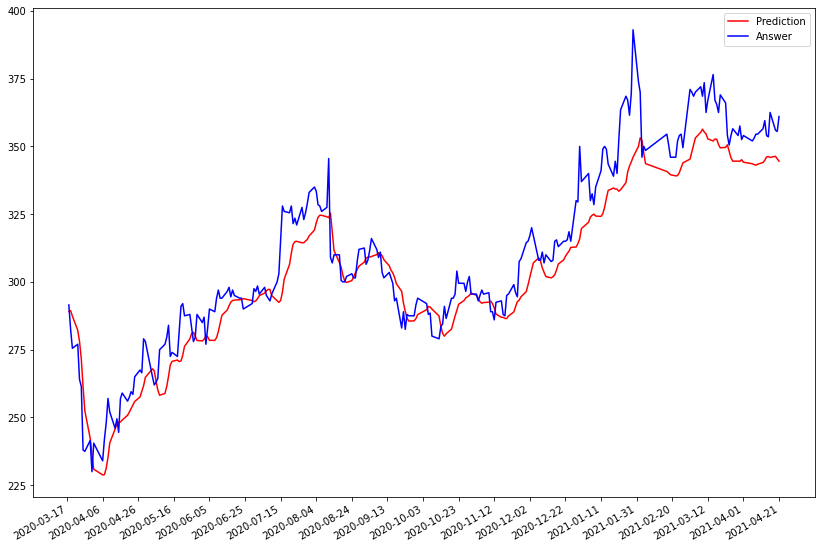

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_42 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

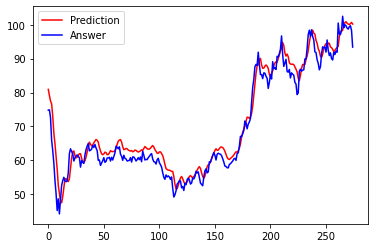

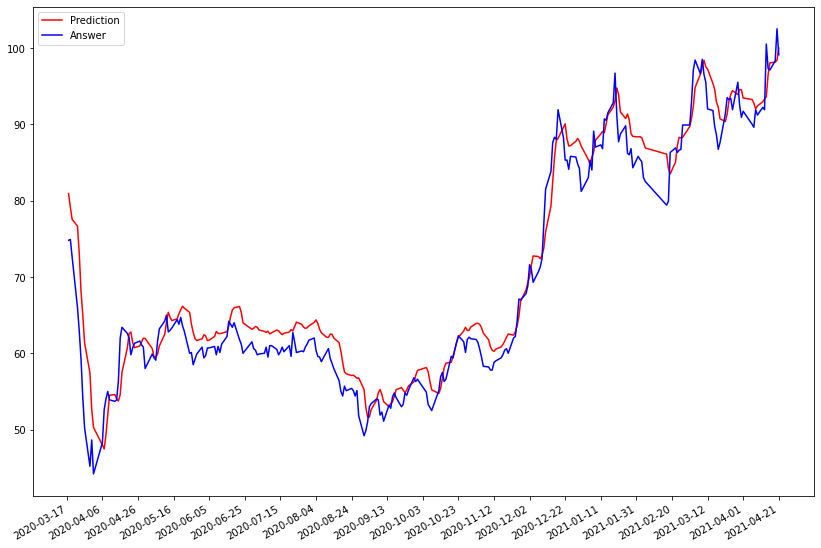

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_44 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

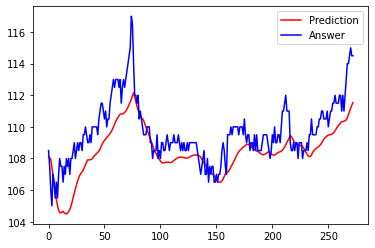

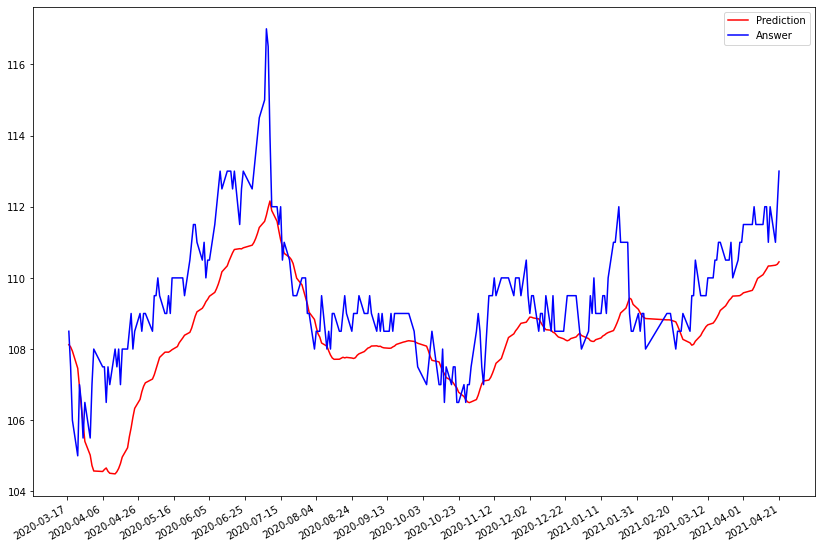

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_46 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

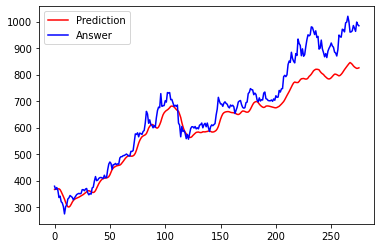

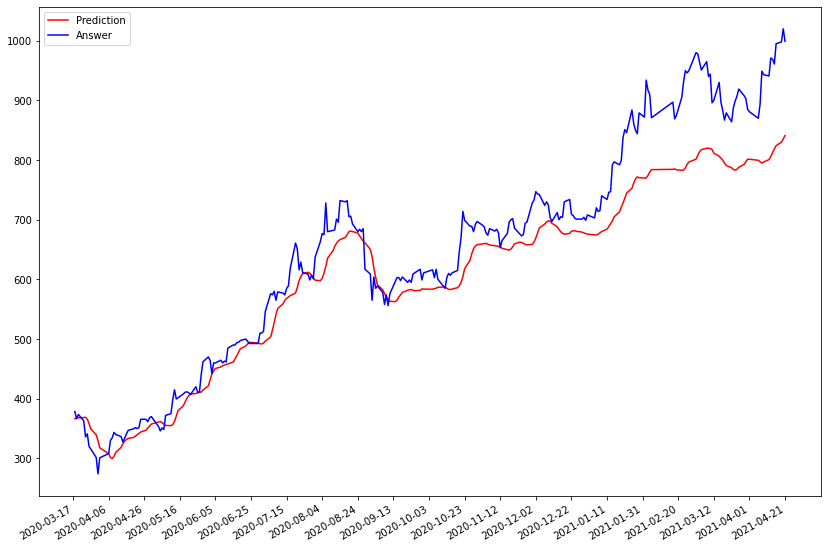

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_48 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

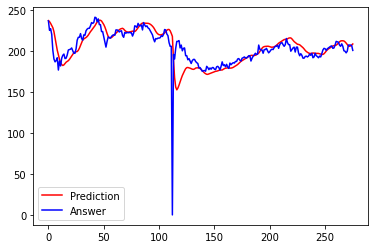

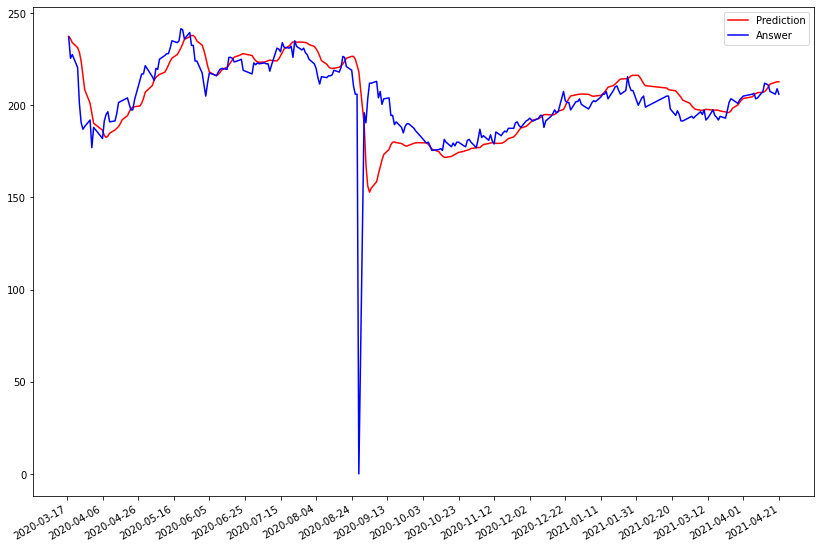

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_50 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

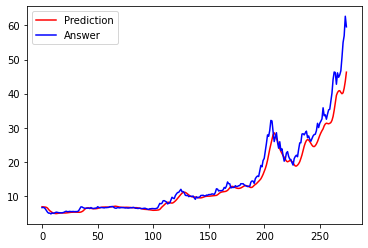

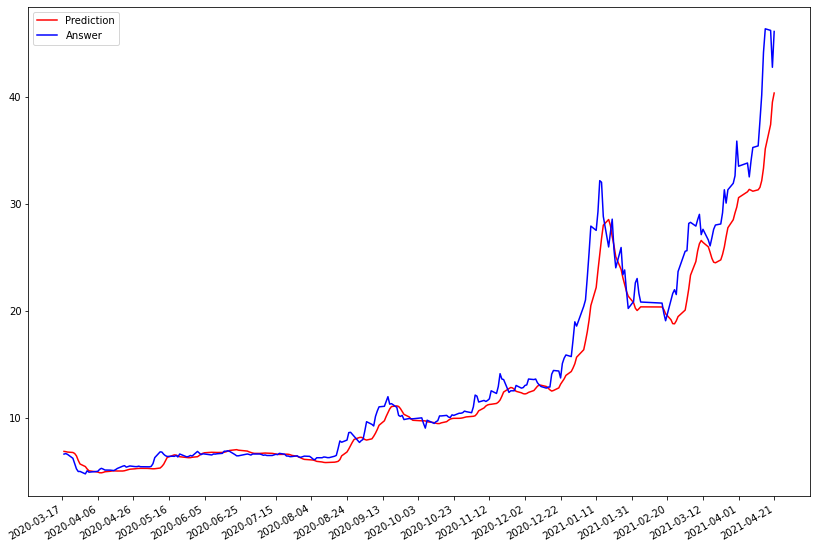

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_52 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

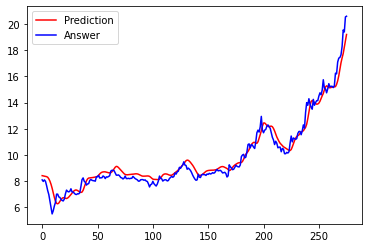

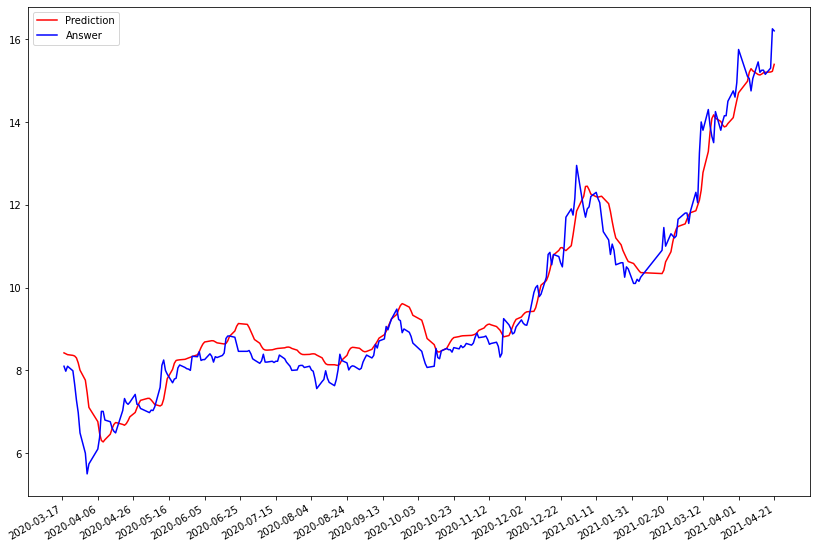

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_54 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_55 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

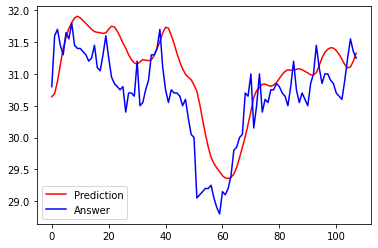

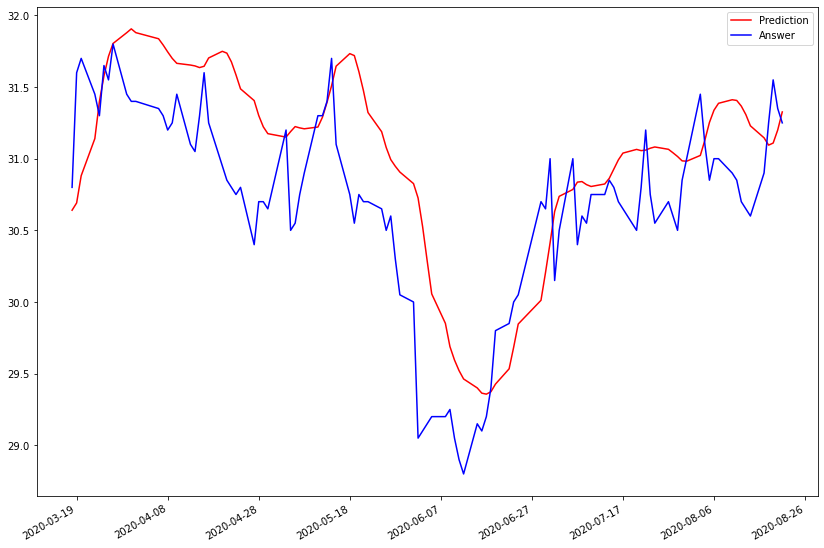

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_56 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

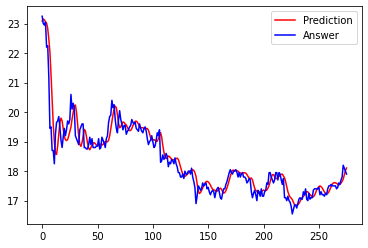

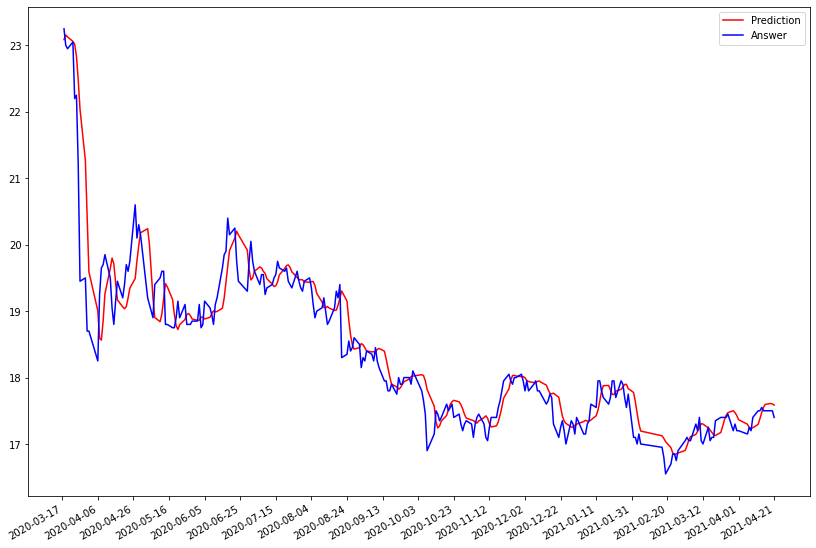

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_58 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

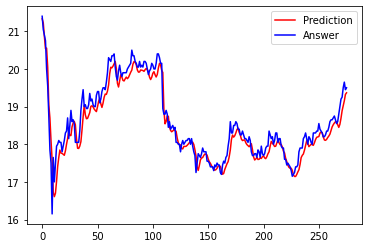

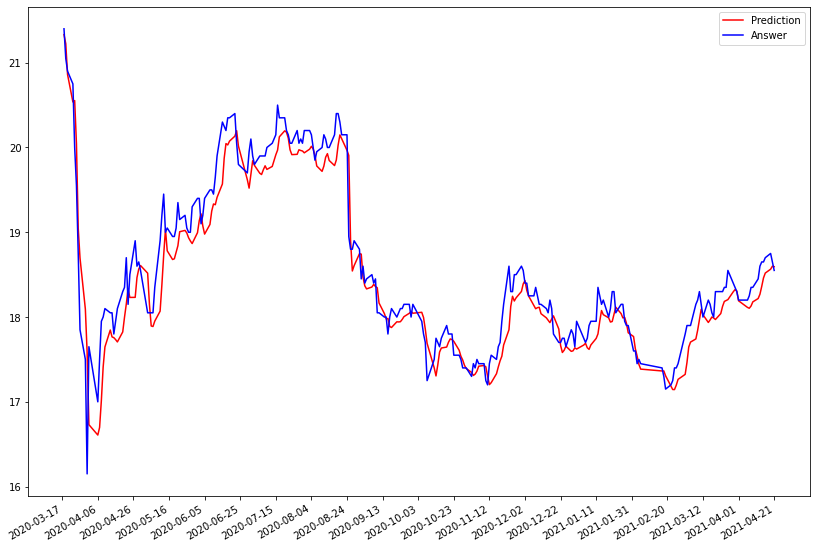

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_60 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

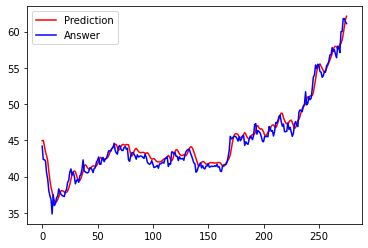

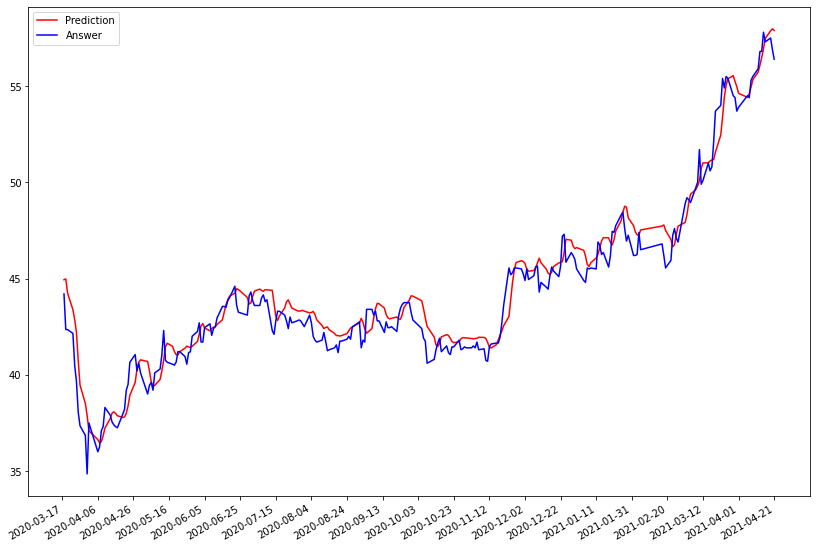

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_62 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

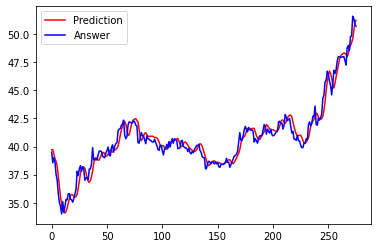

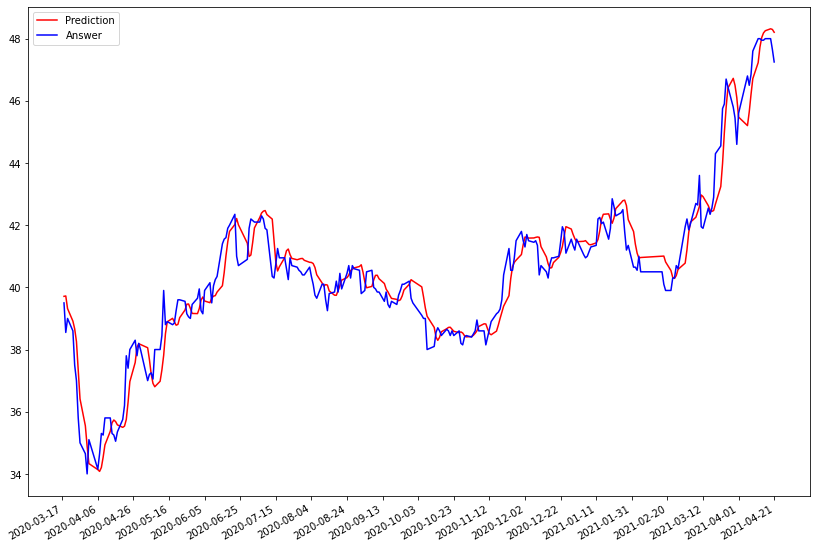

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_64 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

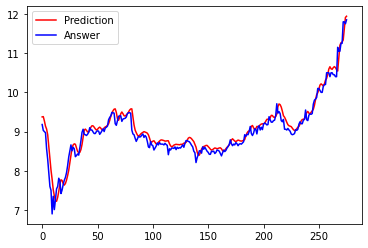

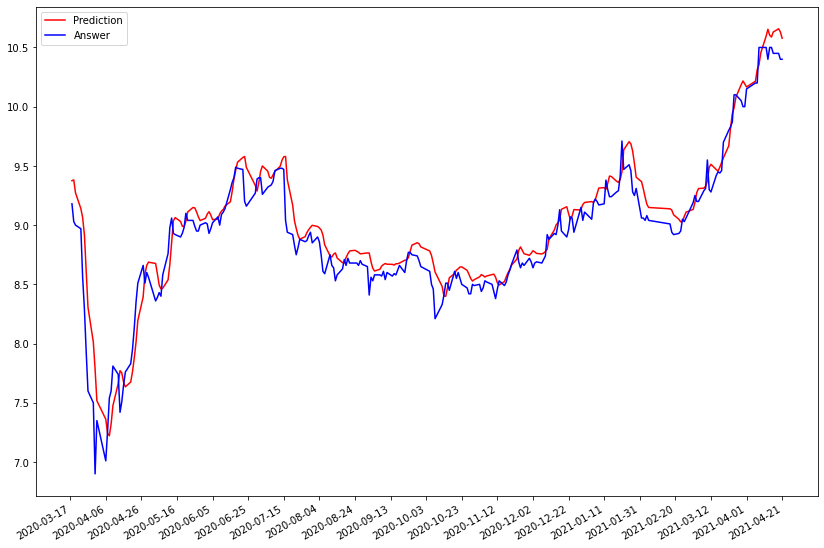

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_66 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

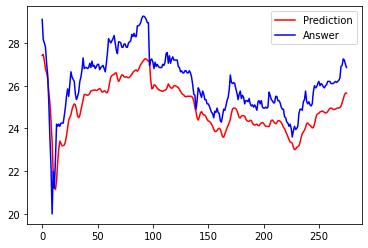

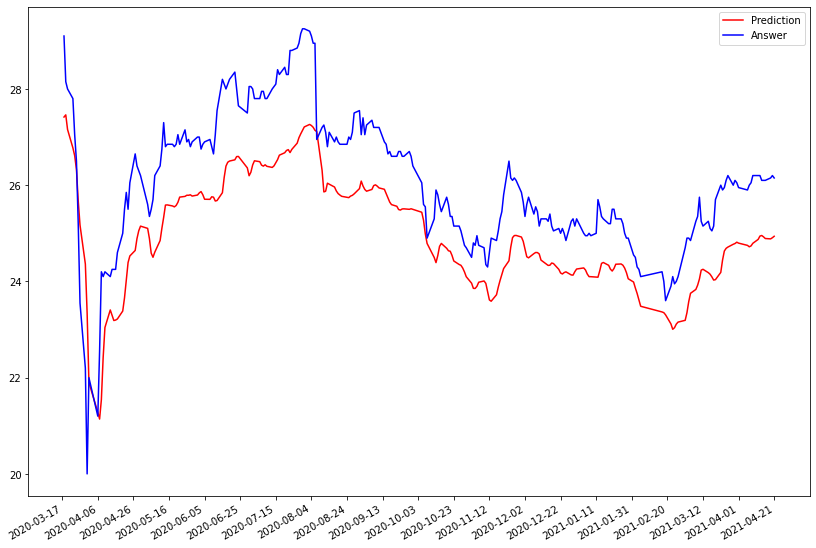

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_68 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

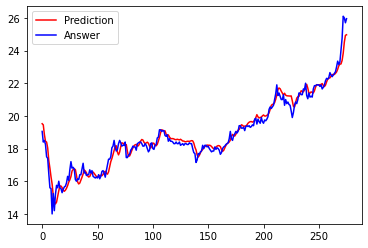

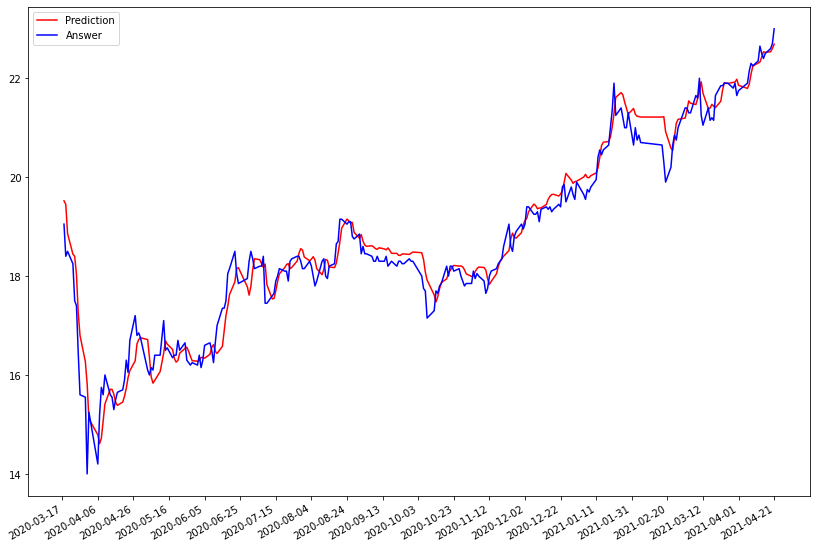

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_70 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

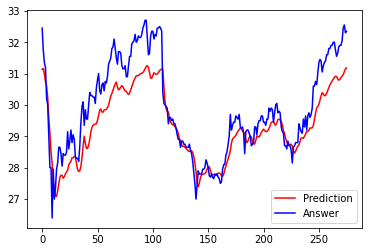

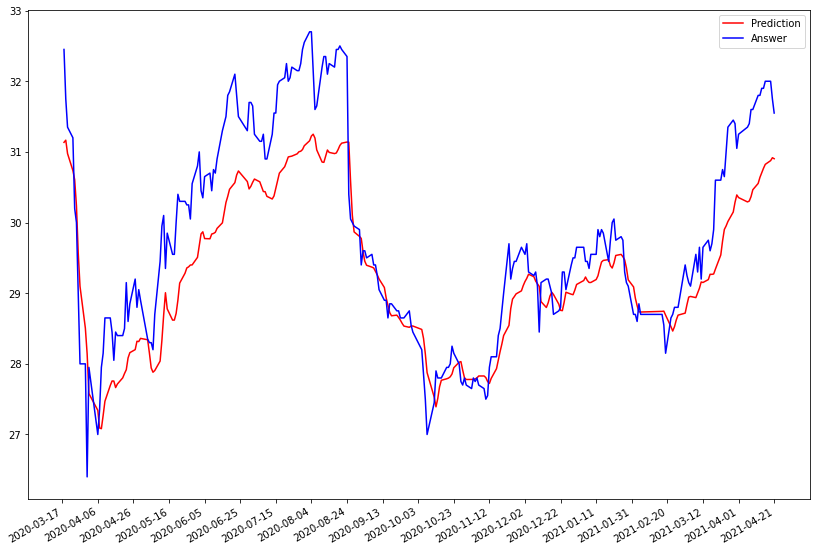

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_72 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

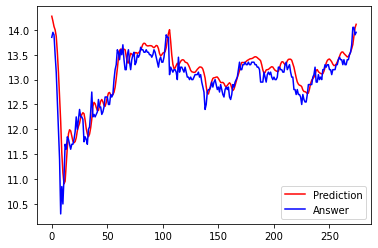

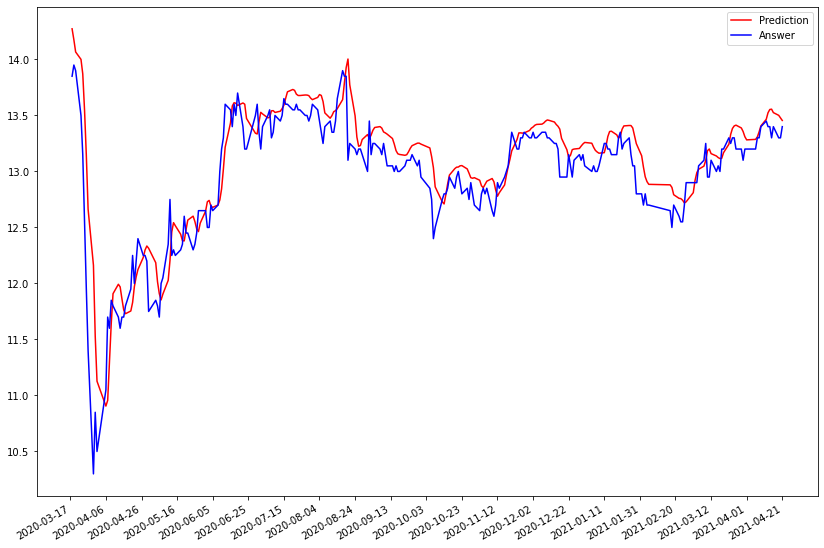

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_74 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

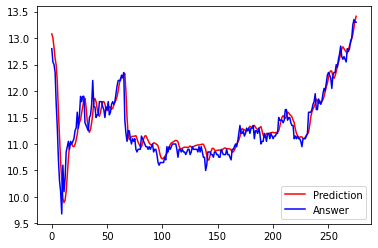

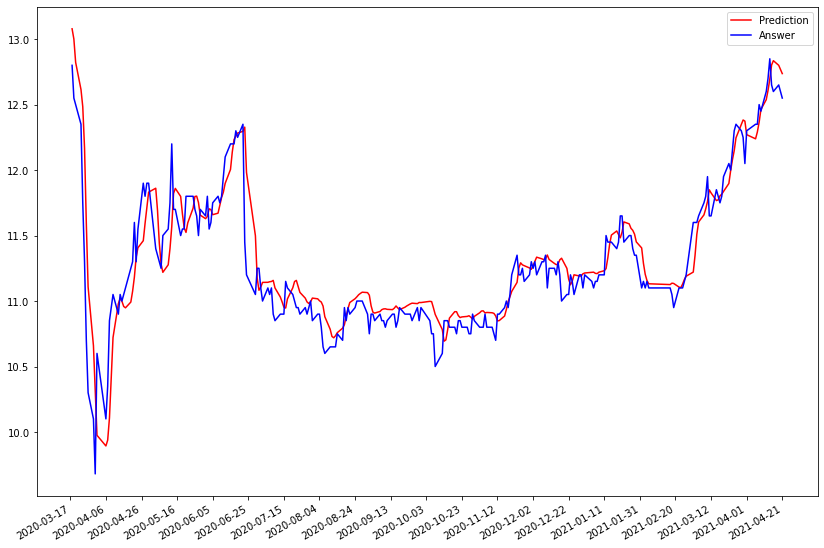

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_76 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

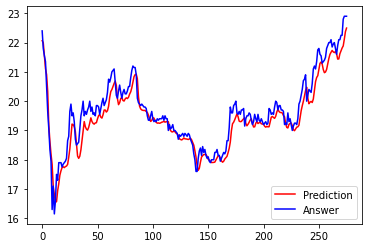

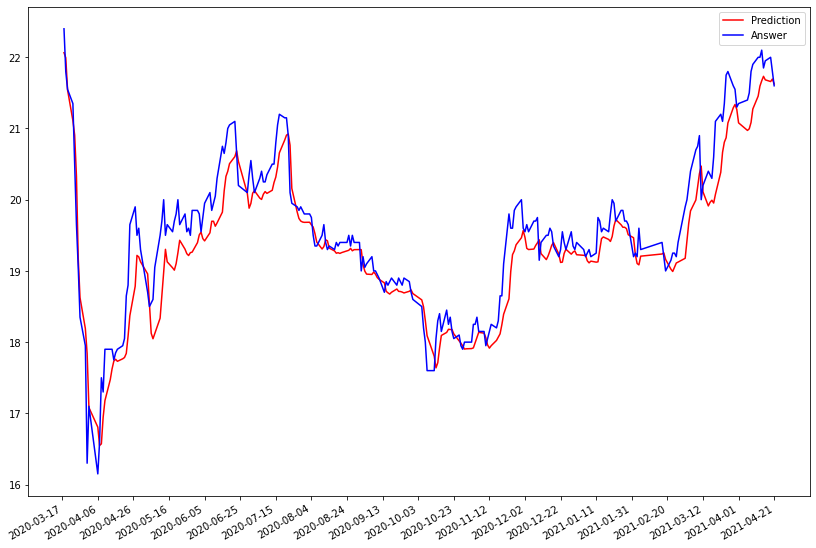

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_78 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

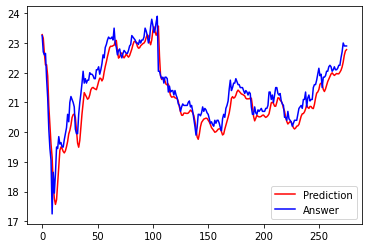

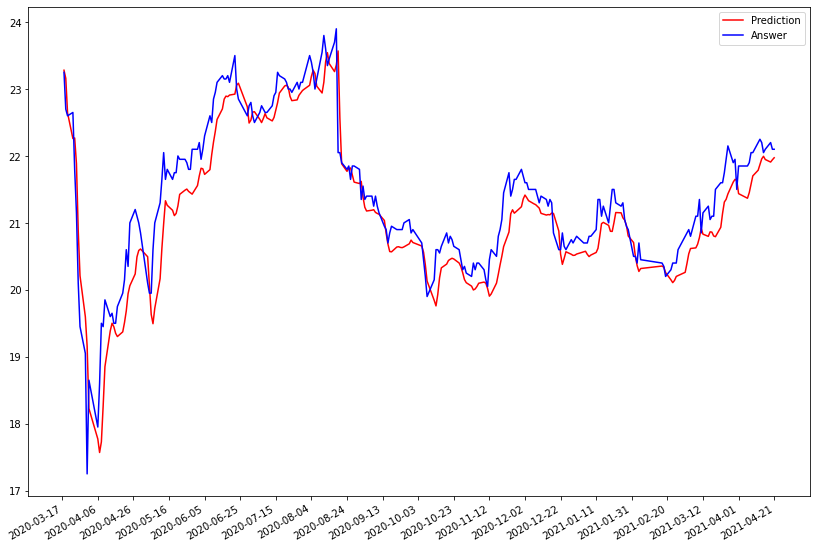

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_80 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

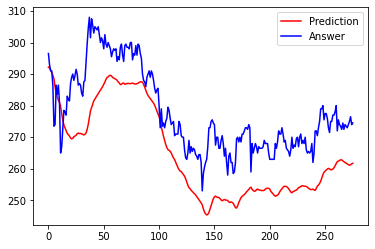

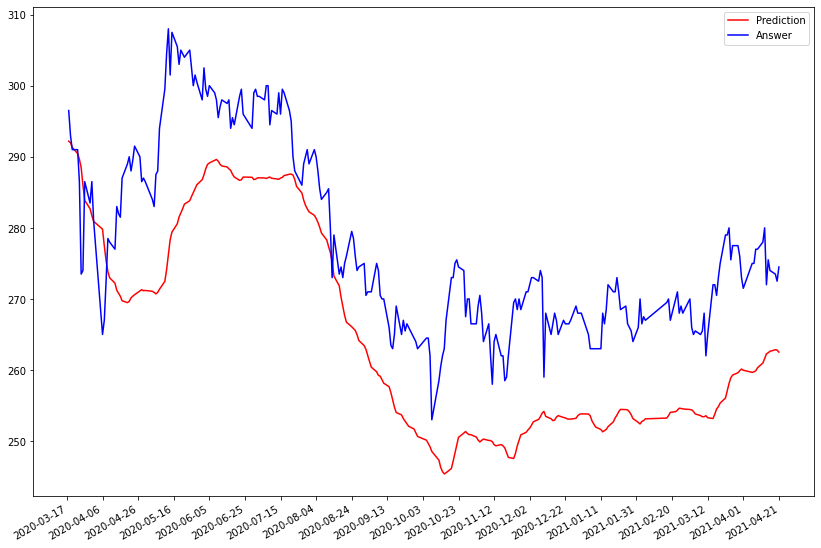

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_82 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

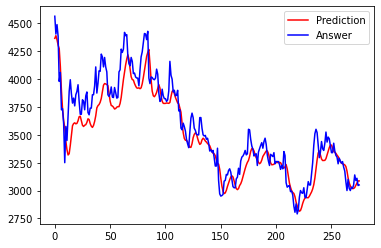

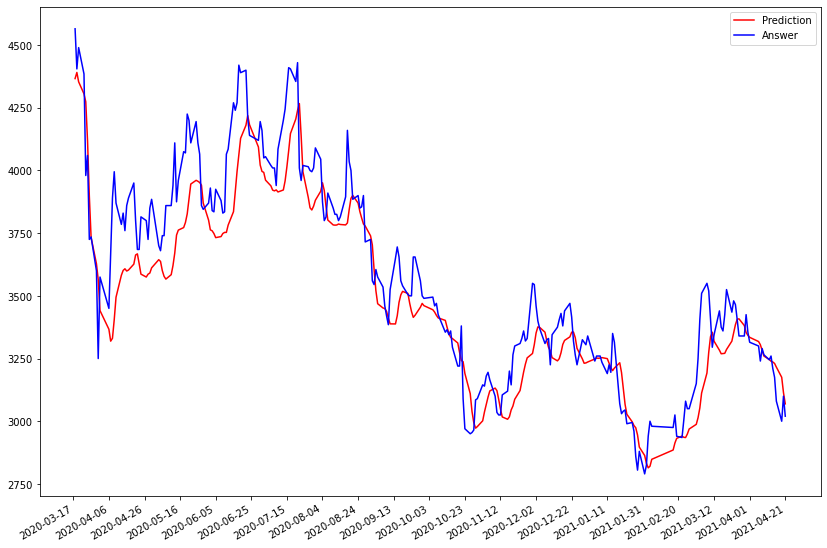

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_84 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

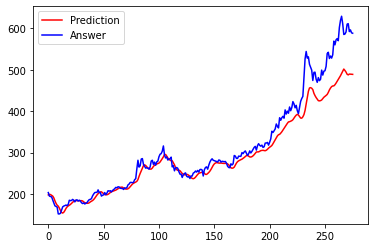

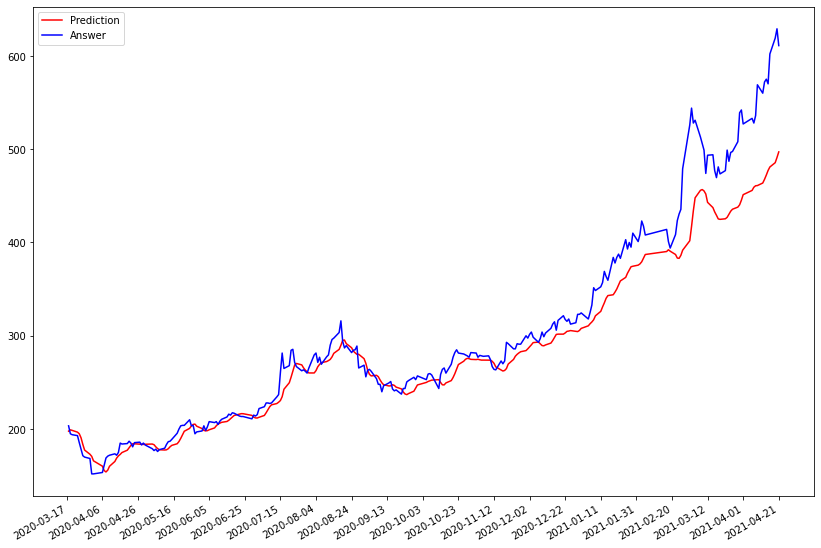

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_86 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_87 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

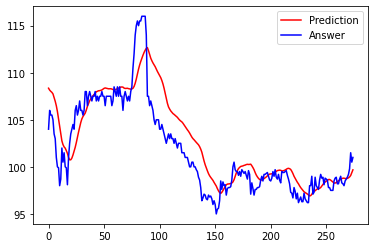

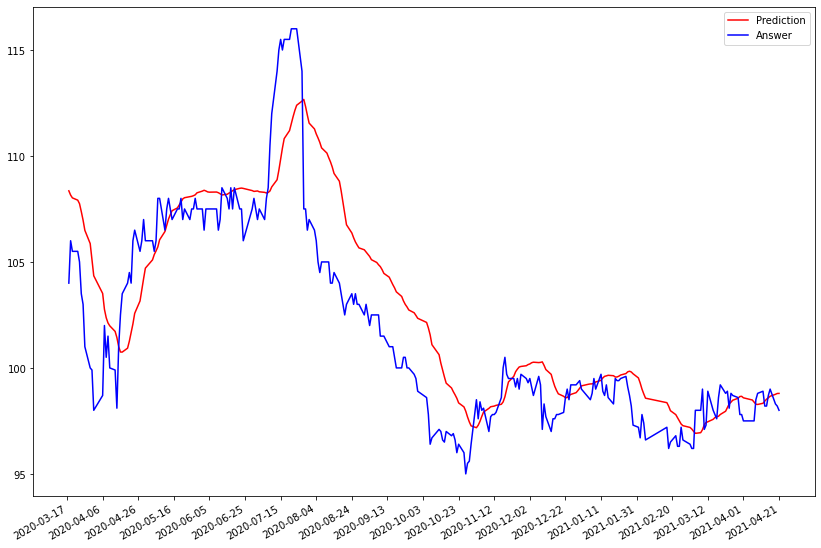

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_88 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_89 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

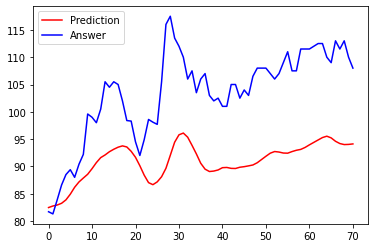

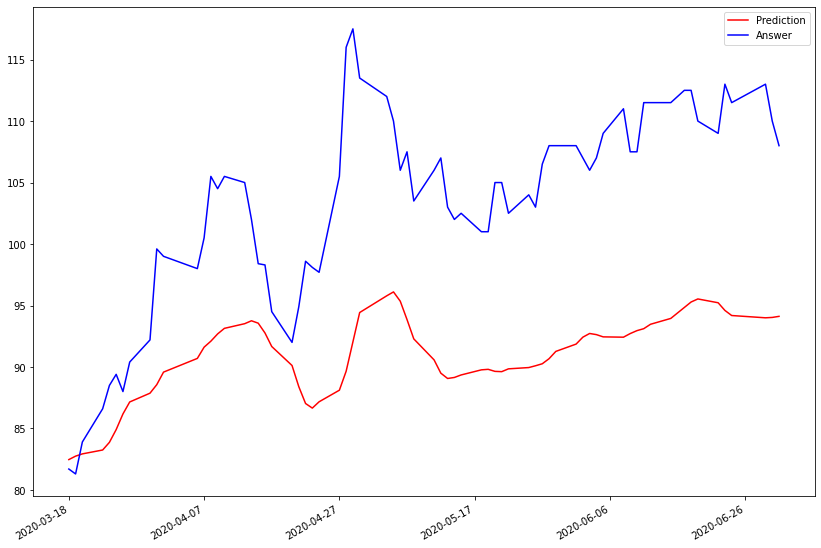

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_90 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_91 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

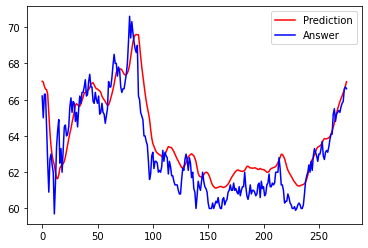

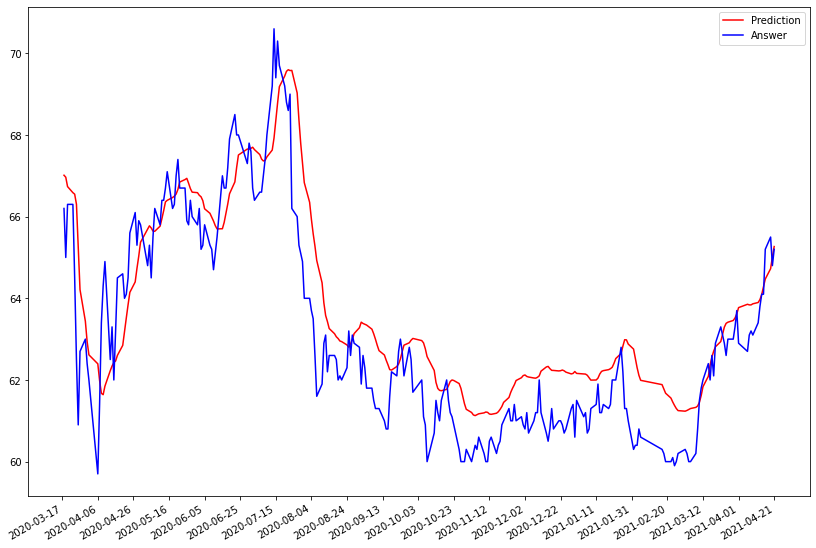

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_92 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_93 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_93 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

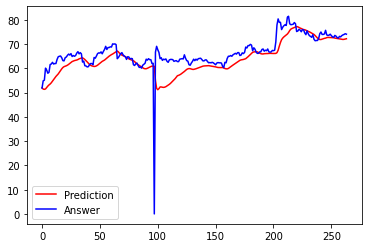

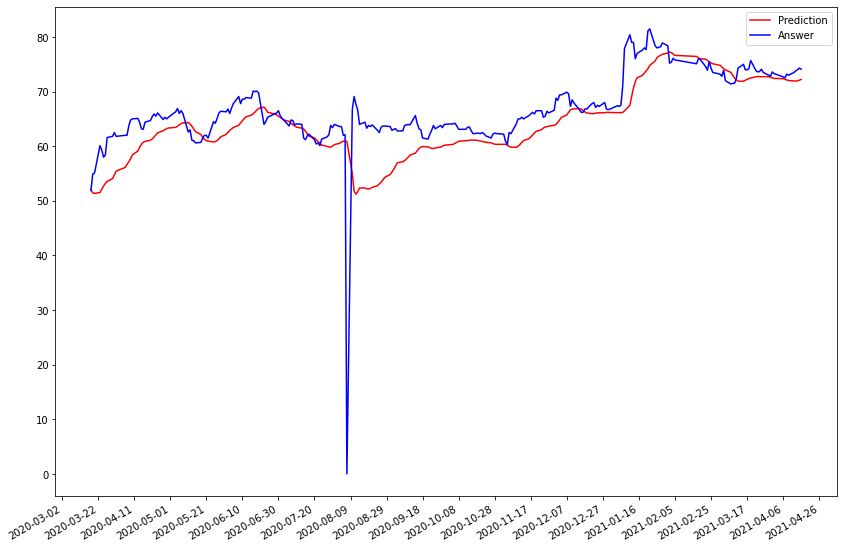

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_94 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_95 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

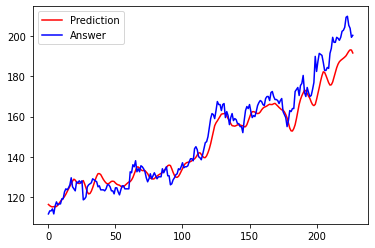

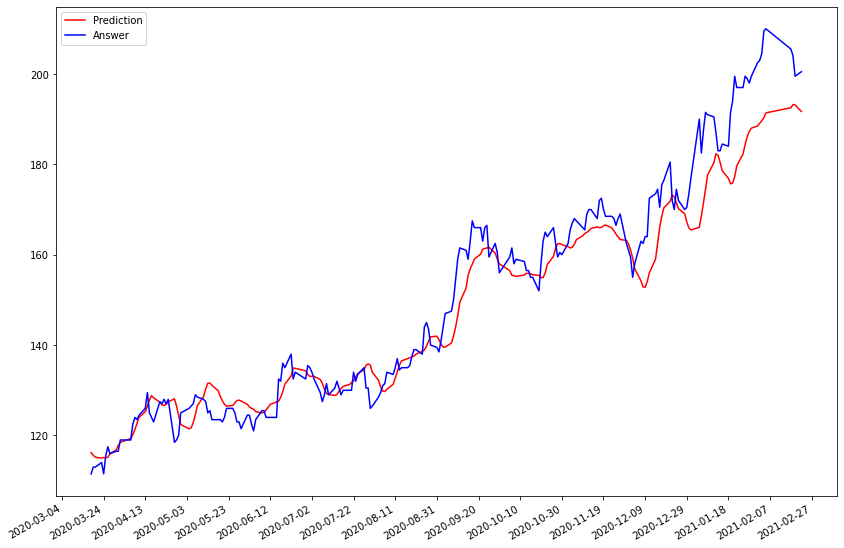

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_96 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_97 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

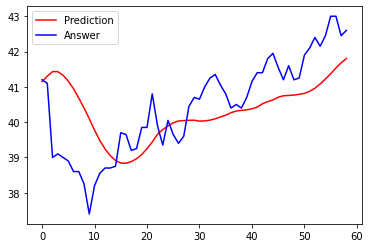

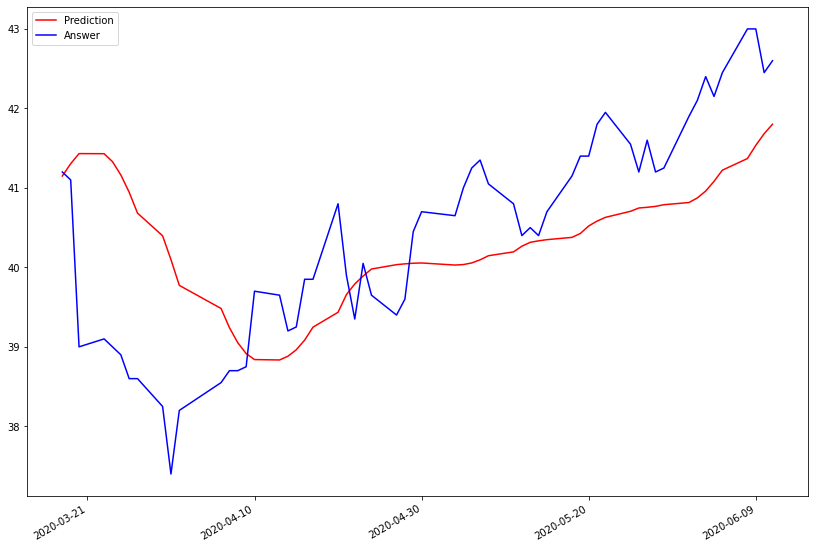

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 20, 256)           274432    
_________________________________________________________________
dropout_98 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_99 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

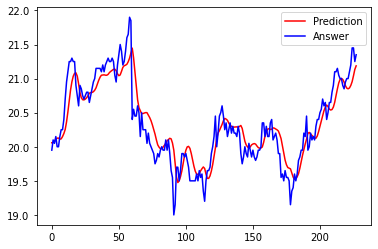

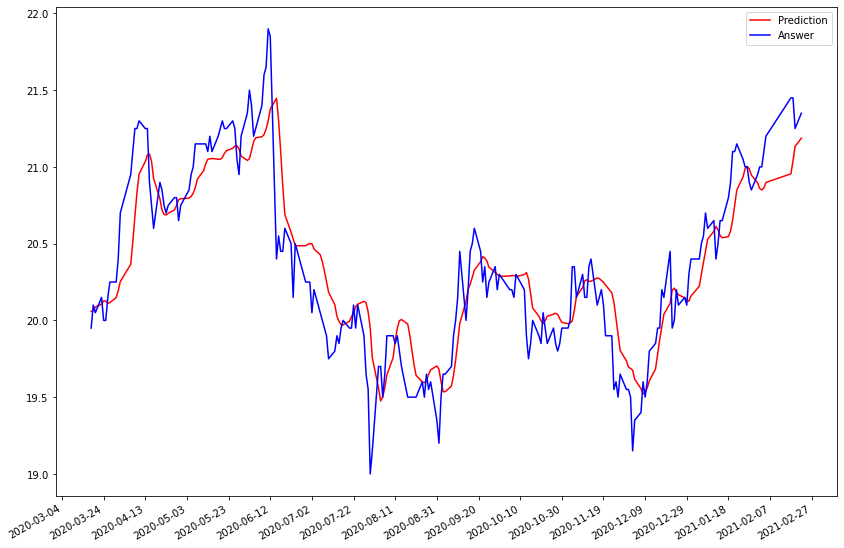

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 20, 256)           274432    
_________________________________________________________________
dropout_100 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
lstm_101 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 16)                4112      
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

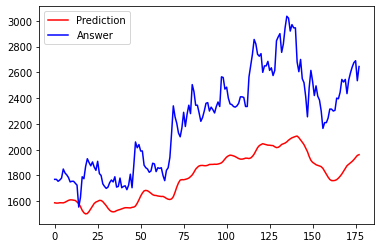

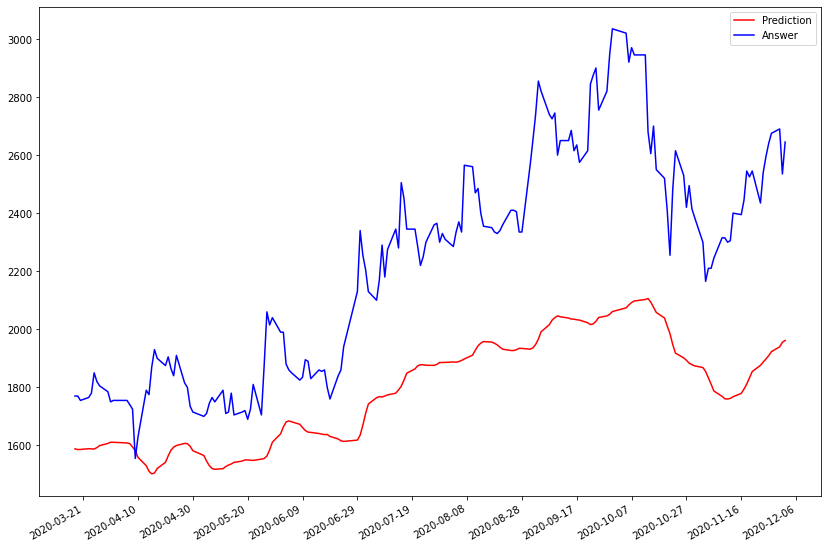

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, 20, 256)           274432    
_________________________________________________________________
dropout_102 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
lstm_103 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_103 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 16)                4112      
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

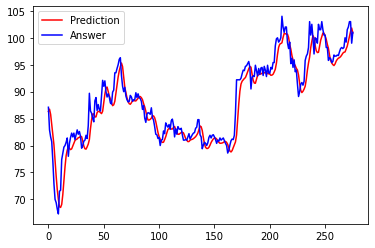

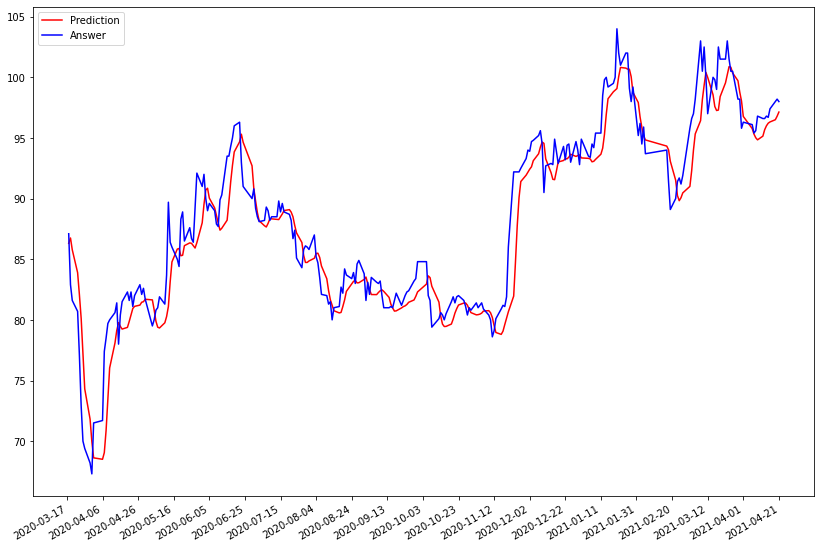

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 20, 256)           274432    
_________________________________________________________________
dropout_104 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
lstm_105 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_105 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 16)                4112      
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

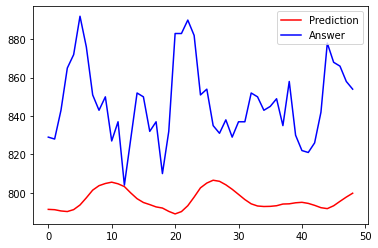

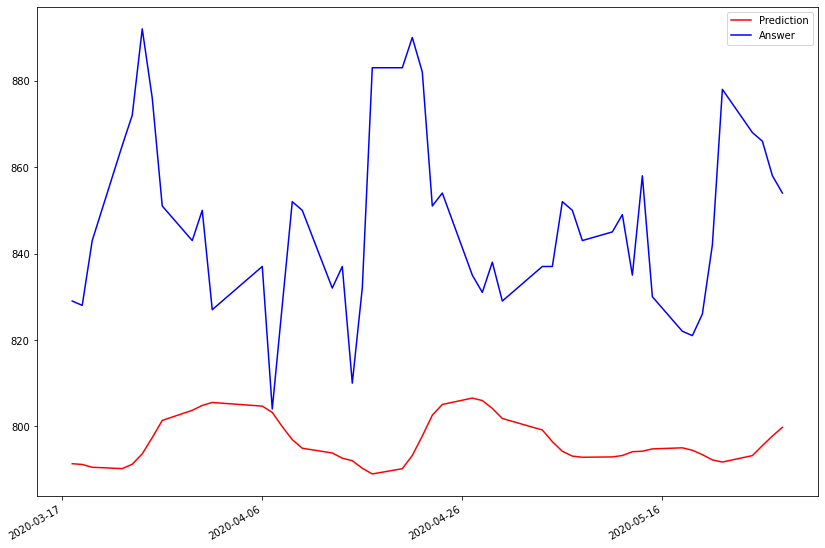

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (None, 20, 256)           274432    
_________________________________________________________________
dropout_106 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
lstm_107 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 16)                4112      
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 17        
Total params: 803,873
Trainable params: 803,873
Non-trainable params: 0
_______________________________________________

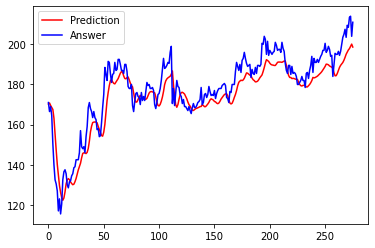

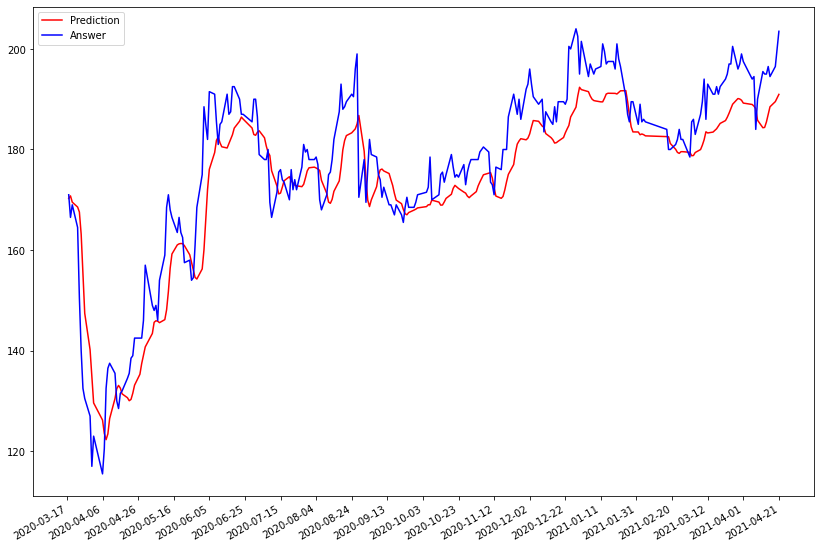

In [8]:
import csv
with open('stock_list.csv',encoding="utf-8") as f:
    list_of_stock = csv.DictReader(f)
    for obj in list_of_stock:
        stock_pred_feature(obj['stock_id'])
        date_list(obj['stock_id'])
        Plot(obj['stock_id'])